# Deep Unsupervised Learning course, HSE, fall-winter 2019
## HW 01
### Student: Igor Tukh

In [47]:
import numpy as np
import torch
import torch.optim
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

In [48]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.nn.functional import one_hot
from tqdm import tqdm_notebook as tqdm

In [49]:
RESOURCES_PATH = './resources'
DATA_PATH = os.path.join(RESOURCES_PATH, 'distribution.npy')

### 2) Two-dimensional data 

In [50]:
np.random.seed(239239)

In [51]:
def sample_data(data_size=100000):
    data = np.load(DATA_PATH)
    data_h, data_w = data.shape
    indexes = np.random.choice(np.arange(data_h * data_w), size=data_size, p=data.reshape(-1))
    return np.array([(index // data_w, index % data_w) for index in indexes])

In [52]:
data = sample_data()

In [53]:
train_data, test_data = train_test_split(data, train_size=0.8, shuffle=False, random_state=239239)

In [54]:
test_data = torch.from_numpy(test_data)
train_data = torch.from_numpy(train_data)

In [55]:
batch_size = 200
batches = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

#### MLP

Let's rewrite model from the first task in more convient format.

In [23]:
class OneDimensionalModel(torch.nn.Module):
    def __init__(self):
        super(OneDimensionalModel, self).__init__()
        self.thetas = thetas = torch.zeros(200, requires_grad=True)
        self.softmax = torch.nn.Softmax(dim=0)
        
    def forward(self, x):
        # return self.softmax(self.thetas)[x]
        return torch.exp(self.thetas[x]) / torch.sum(torch.exp(self.thetas))
    
    def parameters(self):
        return self.thetas

In [24]:
class TwoDimensionalModel(torch.nn.Module):
    def __init__(self):
        super(TwoDimensionalModel, self).__init__()
        self.one_dimensional_model = OneDimensionalModel()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(200, 200),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(200, 200),
            torch.nn.Dropout(0.05),
            torch.nn.Softmax())
    
    def forward(self, x):
        n_samples = x.shape[0]
        x1 = x[:, 0]
        x2 = x[:, 1]
        p1 = self.one_dimensional_model(x1)
        one_hot_x1 = one_hot(x1, 200).float()
        p2 = self.model(one_hot_x1)
        p2 = p2[np.arange(n_samples), x2]
        return p1 * p2
    
    def parameters(self):
        return [*self.model.parameters(), self.one_dimensional_model.parameters()]

In [25]:
# less verbose than in the previous task
def get_loss(values):
    return -torch.sum(torch.log(values))

In [26]:
epochs_number = 20

In [28]:
model = TwoDimensionalModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

losses = []
test_losses = []

for epoch in tqdm(range(epochs_number)):
    for batch in batches:
        optimizer.zero_grad()
        output = model(batch)
        loss = get_loss(output)
        loss.backward()
        losses.append(loss / batch.shape[0])
        optimizer.step()
    
        with torch.no_grad():
            test_output = model(test_data)
            test_losses.append(get_loss(test_output) / test_data.shape[0])
    if epoch % 2 == 0 or epoch == epochs_number - 1:
        print(f'Epoch: {epoch}, loss: {losses[-1]}, test loss: {test_losses[-1]}')

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0, loss: 10.559459686279297, test loss: 10.559273719787598
Epoch: 2, loss: 10.54710578918457, test loss: 10.55773639678955
Epoch: 4, loss: 10.534146308898926, test loss: 10.554601669311523
Epoch: 6, loss: 10.504753112792969, test loss: 10.55861759185791
Epoch: 8, loss: 10.50267219543457, test loss: 10.570792198181152
Epoch: 10, loss: 10.444746971130371, test loss: 10.58815860748291
Epoch: 12, loss: 10.428353309631348, test loss: 10.59952163696289
Epoch: 14, loss: 10.421839714050293, test loss: 10.622483253479004
Epoch: 16, loss: 10.423181533813477, test loss: 10.637954711914062
Epoch: 18, loss: 10.376343727111816, test loss: 10.647964477539062
Epoch: 19, loss: 10.383517265319824, test loss: 10.652861595153809



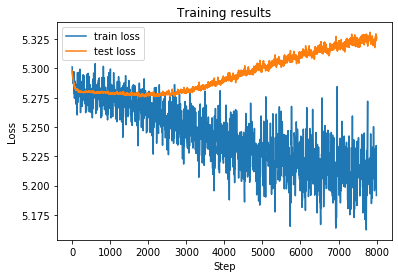

In [40]:
plt.clf()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training results')
epochs = np.arange(len(losses)) 
plt.plot(epochs[::5], np.array(losses[::5]) / 2, label = 'train loss')
plt.plot(epochs[::1], np.array(test_losses[::1]) / 2, label = 'test loss')
plt.legend()
plt.show()

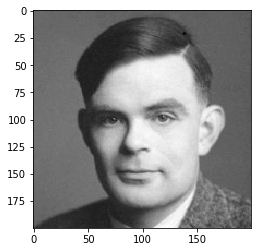

In [30]:
%matplotlib inline

plt.imshow(np.load('./resources/distribution.npy'), cmap='gray')

In [36]:
pairs = np.transpose([np.tile(np.arange(200), 200), np.repeat(np.arange(200), 200)])[:,[1, 0]]
model_data = model(torch.tensor(pairs))
model_data = model_data.detach().numpy().reshape(200, 200)

Now let's plot the same image with predicted probabilities.

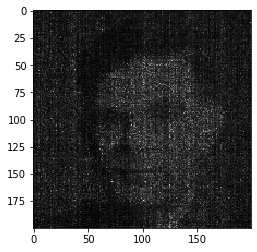

In [37]:
%matplotlib inline

plt.imshow(model_data, cmap='gray')

We can make out real conturs.

Now let's plot samples.

Real samples.

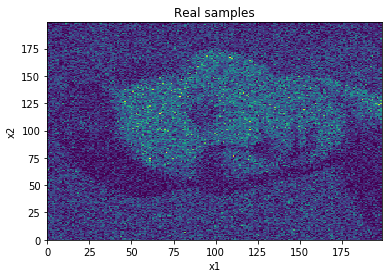

In [46]:
plt.hist2d(data[:,0], data[:,1], bins=[200, 200], range=np.array([[0,199], [0,199]]))
plt.title("Real samples")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

Now let's sample data via estimated distribution.

In [54]:
pairs = np.transpose([np.tile(np.arange(200), 200), np.repeat(np.arange(200), 200)])[:,[1, 0]]
model_data = model(torch.tensor(pairs))
model_data = model_data.detach().numpy().reshape(200, 200)
model_data = model_data / model_data.sum()
indexes = np.random.choice(np.arange(200 * 200), size=100000, p=model_data.reshape(-1))
model_samples = np.array([(index // 200, index % 200) for index in indexes])

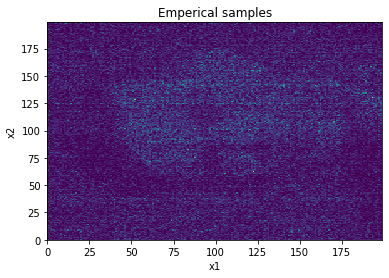

In [59]:
plt.hist2d(model_samples[:,0], model_samples[:,1], bins=[200, 200], range=np.array([[0,199], [0,199]]))
plt.title("Emperical samples")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

#### Masked Autoencoder for Distribution Estimation (MADE)

In [15]:
class MaskedLinear(torch.nn.Linear):
    def __init__(self, shape, mask):
        super(MaskedLinear, self).__init__(*shape)
        self.mask = mask.float()
    
    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)

In [21]:
class MADE(torch.nn.Module):
    def __init__():
        super(MADE, self).__init__()
        self.model = torch.nn.Sequential(MaskedLinear, 
                                         torch.nn.ReLU(),
                                         MaskedLinear, 
                                         torch.nn.ReLU(),
                                         MaskedLinear)
    
    def parametrs():
        return self.model.parametrs()

In [58]:
m = [np.repeat(np.arange(2), 10) + 1]
for i in range(1):
    m += [np.random.randint(m[-1].min(), 2, size=10)]
m

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]